!["Anaconda"](img/anaconda-logo.png)
<br>
*Copyright Continuum 2012-2016 All Rights Reserved.*

# Dask Arrays

<img src="img/array.png" width="20%" align="right">

Dask array provides a parallel, larger-than-memory, n-dimensional array using blocked algorithms.

*  **Parallel**: Uses all of the cores on your computer
*  **Larger-than-memory**:  Lets you work on datasets that are larger than your available memory by breaking up your array into many small pieces, operating on those pieces in an order that minimizes the memory footprint of your computation, and effectively streaming data from disk.
*  **Blocked Algorithms**:  Perform large computations by performing many smaller computations

**Related Documentation**

* http://dask.readthedocs.org/en/latest/array.html
* http://dask.readthedocs.org/en/latest/array-api.html

## Table of Contents
* [Dask Arrays](#Dask-Arrays)
	* [Set-up](#Set-up)
* [Blocked Algorithms](#Blocked-Algorithms)
	* [Example Blocked Algorithm: Sum](#Example-Blocked-Algorithm:-Sum)
	* [Create random dataset](#Create-random-dataset)
	* [Compute sum using blocked algorithm](#Compute-sum-using-blocked-algorithm)
* [Exercise 1:  Compute the mean using a blocked algorithm](#Exercise-1:--Compute-the-mean-using-a-blocked-algorithm)
	* [Solution](#Solution)
* [Blocked Algorithms with `dask.array`](#Blocked-Algorithms-with-dask.array)
	* [Create `dask.array` object](#Create-dask.array-object)
	* [Manipulate `dask.array` object as you would a numpy array](#Manipulate-dask.array-object-as-you-would-a-numpy-array)
	* [What's the difference?](#What's-the-difference?)
	* [Why the difference?](#Why-the-difference?)
	* [Compute the result](#Compute-the-result)
	* [Exercise:  Compute the mean of x](#Exercise:--Compute-the-mean-of-x)
* [Performance and Parallelism](#Performance-and-Parallelism)
	* [Example: Every 100th Mean of Random](#Example:-Every-100th-Mean-of-Random)
	* [Performance comparision](#Performance-comparision)
		* [NumPy: 19s, Needs gigabytes of memory](#NumPy:-19s,-Needs-gigabytes-of-memory)
		* [Dask Array: 4s, Needs megabytes of memory](#Dask-Array:-4s,-Needs-megabytes-of-memory)
		* [Discussion](#Discussion)
		* [Questions](#Questions)
* [Exercise 2:  Meteorological data](#Exercise-2:--Meteorological-data)
	* [Integrate with `dask.array`](#Integrate-with-dask.array)
	* [Stack this list of `dask.array` objects into a single `dask.array` object with `da.stack`](#Stack-this-list-of-dask.array-objects-into-a-single-dask.array-object-with-da.stack)
	* [Plot the mean of this array along the time (`0th`) axis](#Plot-the-mean-of-this-array-along-the-time-%280th%29-axis)
	* [Plot the difference of the first day from the mean](#Plot-the-difference-of-the-first-day-from-the-mean)
	* [Solution](#Solution)
* [Exercise 3:  Subsample and store](#Exercise-3:--Subsample-and-store)
	* [Solution](#Solution)
* [Limitations](#Limitations)


## Set-up

In [1]:
import dask
dask.__version__

'0.11.0'

In [ ]:
# If the import failed, you may need to install dask
!conda install -y dask

# Blocked Algorithms

To appreciate what Dask does, we first consider the **general case of blocked algorithms.**

A *blocked algorithm* executes on a large dataset by breaking it up into many small blocks.

## Example Blocked Algorithm: Sum

For example, consider taking the sum of a billion numbers.

* We might instead break up the array into 1,000 chunks, each of size 1,000,000, 
* take the sum of each chunk, 
* and then take the sum of the intermediate sums.

We achieve the intended result by performing many smaller results:

* intended result = (one sum, billion numbers)
* many smaller actions = (thousand sums, million numbers)
* final action = (sum the 1000 chunks)

We do exactly this with Python and NumPy in the following example:

In [5]:
!pip install h5py

## Create random dataset

In [30]:
# create data if it doesn't already exist
%time
import sys
sys.path.append('../src')
#import dask_prep
from dask_prep import random_array
random_array()  

# Load data with h5py
import h5py
import os
#f = h5py.File(os.path.join('tmp', 'random.hdf5'))
f = h5py.File('./tmp/random.hdf5')
dset = f['/x']

Wall time: 0 ns


KeyError: "Unable to open object (object 'x' doesn't exist)"

In [64]:
f

<HDF5 file "random.hdf5" (mode r+)>

In [ ]:
dset

In [ ]:
dset.name, dset.dtype, dset.ndim, dset.shape, dset.size

## Compute sum using blocked algorithm

Here we compute the sum of this large array on disk by 

1.  Computing the sum of each 1,000,000 sized chunk of the array
2.  Computing the sum of the 1,000 intermediate sums

In [ ]:
# Compute sum of large array, one million numbers at a time
sums = []
total_size = 100000000
chunk_size = 1000000
for i in range(0, total_size, chunk_size):
    chunk = dset[i: i + chunk_size]  # pull out numpy array
    sums.append(chunk.sum())

total = sum(sums)
print(total)

# Exercise 1:  Compute the mean using a blocked algorithm

Now that we've seen the simple example above try doing a slightly more complicated problem, compute the mean of the array.  You can do this by changing the code above with the following alterations:

1.  Compute the sum of each block
2.  Compute the length of each block
3.  Compute the sum of the 1,000 intermediate sums and the sum of the 1,000 intermediate lengths and divide one by the other

This approach is overkill for our case but does nicely generalize if we don't know the size of the array or individual blocks beforehand.

In [ ]:
# Compute the mean of the array

## Solution

In [ ]:
%load solutions/Array-01.py


# Blocked Algorithms with `dask.array`

Dask.array is a NumPy-like library that does these kinds of blocking machinations to operate on large datasets that don't fit into memory.

It extends beyond the linear problems discussed above to full N-Dimensional algorithms and a decent subset of the NumPy interface.

## Create `dask.array` object

You can create a `dask.array` `Array` object with the `da.from_array` function.  This function accepts

1.  `data`: Any object that supports NumPy slicing, like `dset`
2.  `chunks`: A chunk size to tell us how to block up our array, like `(1000000,)`

In [ ]:
import dask.array as da
chunk_size = 1000000
x = da.from_array(dset, chunks=(chunk_size,))

## Manipulate `dask.array` object as you would a numpy array

Now that we have an `Array` we perform standard numpy-style computations like arithmetic, mathematics, slicing, reductions, etc..

The interface is familiar, but the actual work is different. 

dask_array.sum() does not do the same thing as numpy_array.sum().

## What's the difference?

`numpy_array.sum()` computes the sum immediately.

`dask_array.sum()` builds an ***expression of the computation. ***

Dask does not do the computation yet. Until you call `compute()`...



## Why the difference?

Dask arrays are split into chunks. Each chunk must have computations run on that chunk explicitly. If the desired answer comes from a small slice of the entire dataset, running the computation over all data would be wasteful of CPU and memory.

In [ ]:
result = x.sum()
result

## Compute the result

Dask.array objects are lazily evaluated.  Operations like `.sum` build up a graph of blocked tasks to execute.  

We ask for the final result with a call to `.compute()`.  This triggers the actual computation.

In [ ]:
result.compute()

## Exercise:  Compute the mean of x

And the variance, std, etc..  This should be a trivial change to the example above.

Look at what other operations you can do with the Jupyter notebook's tab-completion.

In [ ]:
r2 = x.mean()
r2

In [ ]:
r2.compute()

Does this match your result from before?

# Performance and Parallelism

<img src="img/fail-case.gif" width="40%" align="right">

In our first examples we used `for` loops to walk through the array one block at a time.  

For simple operations like `sum` this is optimal.  

However for complex operations we may want to traverse through the array differently.  In particular we may want the following:

1.  Use multiple cores in parallel
2.  Chain operations on a single blocks before moving on to the next one

Dask.array translates your array operations into a graph of inter-related tasks with data dependencies between them.  Dask then executes this graph in parallel with multiple threads.  We'll discuss more about this in the next section.

## Example: Every 100th Mean of Random

1.  Construct a 20000x20000 array of normally distributed random values broken up into 1000x1000 sized chunks
2.  Take the mean along one axis
3.  Take every 100th element

In [31]:
import numpy as np
import dask.array as da

x = da.random.normal(10, 0.1, size=(20000, 20000),   # 400 million element array 
                              chunks=(1000, 1000))   # Cut into 1000x1000 sized chunks
y = x.mean(axis=0)[::100]                            # Perform NumPy-style operations

In [32]:
x.nbytes / 1e9  # Gigabytes of the input processed lazily

3.2

In [33]:
%%time
y.compute()     # Time to compute the result

Wall time: 7.92 s


array([ 10.000187  ,  10.00080042,   9.99814407,  10.00053443,
        10.00055983,   9.99879915,   9.99984363,  10.00076816,
        10.00067827,   9.99990285,  10.00098512,   9.99956166,
         9.99962725,  10.00057793,  10.00032058,   9.99971853,
        10.00074221,  10.00001259,  10.000018  ,   9.99908402,
        10.00107863,   9.99916884,  10.00036821,   9.99951279,
         9.9998271 ,   9.99987546,   9.99982704,  10.00118228,
        10.00108864,  10.00030638,   9.99878469,  10.00103523,
         9.99952627,  10.00055415,  10.00069885,  10.00083581,
         9.9995897 ,  10.00011139,   9.99918645,  10.00044875,
        10.00031018,   9.99911261,   9.99993336,  10.0001704 ,
         9.99956637,   9.99893042,  10.00012945,   9.99898918,
        10.00108422,   9.99976003,  10.00014425,   9.99847935,
         9.99981173,  10.00117319,   9.99880727,   9.9993656 ,
        10.00067171,   9.99980997,   9.99930768,   9.99887802,
         9.99985945,   9.99955569,  10.00016978,  10.00

## Performance comparision

The following experiment was performed on a heavy personal laptop.  Your performance may vary.  If you attempt the NumPy version then please ensure that you have more than 4GB of main memory.

In [34]:
import numpy as np

In [35]:
x = np.linspace(1,100,100)
print(x)

[   1.    2.    3.    4.    5.    6.    7.    8.    9.   10.   11.   12.
   13.   14.   15.   16.   17.   18.   19.   20.   21.   22.   23.   24.
   25.   26.   27.   28.   29.   30.   31.   32.   33.   34.   35.   36.
   37.   38.   39.   40.   41.   42.   43.   44.   45.   46.   47.   48.
   49.   50.   51.   52.   53.   54.   55.   56.   57.   58.   59.   60.
   61.   62.   63.   64.   65.   66.   67.   68.   69.   70.   71.   72.
   73.   74.   75.   76.   77.   78.   79.   80.   81.   82.   83.   84.
   85.   86.   87.   88.   89.   90.   91.   92.   93.   94.   95.   96.
   97.   98.   99.  100.]


In [36]:
x[0]

1.0

### NumPy: 19s, Needs gigabytes of memory

In [ ]:
import numpy as np

In [ ]:
%%time 
x = np.random.normal(10, 0.1, size=(100000, 100000)) 
y = x.mean(axis=0)[::100] 
y

### Dask Array: 4s, Needs megabytes of memory

In [37]:
%%time
x = da.random.normal(10, 0.1, size=(20000, 20000), chunks=(1000, 1000))
y = x.mean(axis=0)[::100] 
y.compute() 

Wall time: 7.58 s


### Discussion

Notice that the dask array computation ran in 4 seconds, but used 29.4 seconds of user CPU time. The numpy computation ran in 19.7 seconds and used 19.6 seconds of user CPU time.

Dask finished faster, but used more total CPU time because Dask was able to transparently parallelize the computation because of the chunk size.

### Questions

*  What happens if the dask chunks=(20000,20000)?
    * Will the computation run in 4 seconds?
    * How much memory will be used?

* What happens if the dask chunks=(25,25)?
    * What happens to CPU and memory?

# Exercise 2:  Meteorological data

Our goal is to visualize the average temperature on the surface of the Earth for this month.

* There is 2GB of somewhat artifical weather data in HDF5 files in `tmp/weather-big/*.hdf5`.  
* We'll use the `h5py` library to interact with this data and `dask.array` to compute on it.
* This will require a mean over all of this data.  


We'll do this in the following steps
1.  Create `h5py.Dataset` objects for each of the days of data on disk (`dsets`)
2.  Wrap these with `da.from_array` calls 
3.  Stack these datasets along time with a call to `da.stack`
4.  Compute the mean along the newly stacked time axis with the `.mean()` method
5.  Visualize the result with `matplotlib.pyplot.imshow`

In [38]:
from src.dask_prep import create_weather  # Prep data if it doesn't exist
create_weather()
!ls -lh tmp/weather-big/

Expand weather data for array exercise


'ls' is not recognized as an internal or external command,
operable program or batch file.


In [39]:
!ls -lh data/weather-small

'ls' is not recognized as an internal or external command,
operable program or batch file.


Now read in all the data files, and store in a list comprehension:

In [40]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-small', '*.hdf5')))
dsets = [h5py.File(filename)['/t2m'] for filename in filenames]

Inspect the first data set:

In [41]:
dsets[0]

<HDF5 dataset "t2m": shape (180, 360), type "<f8">

Slice out some of the data from the first data set:

In [42]:
dsets[0][:5, :5]  # Slicing into h5py.Dataset object gives a numpy array

array([[ 84.75,  84.75,  84.75,  84.75,  84.75],
       [ 83.  ,  83.  ,  83.  ,  83.  ,  83.  ],
       [ 84.5 ,  84.  ,  84.  ,  84.  ,  84.  ],
       [ 81.25,  81.25,  81.25,  81.25,  81.25],
       [ 77.75,  77.75,  77.75,  77.75,  77.75]])

Plot the data:

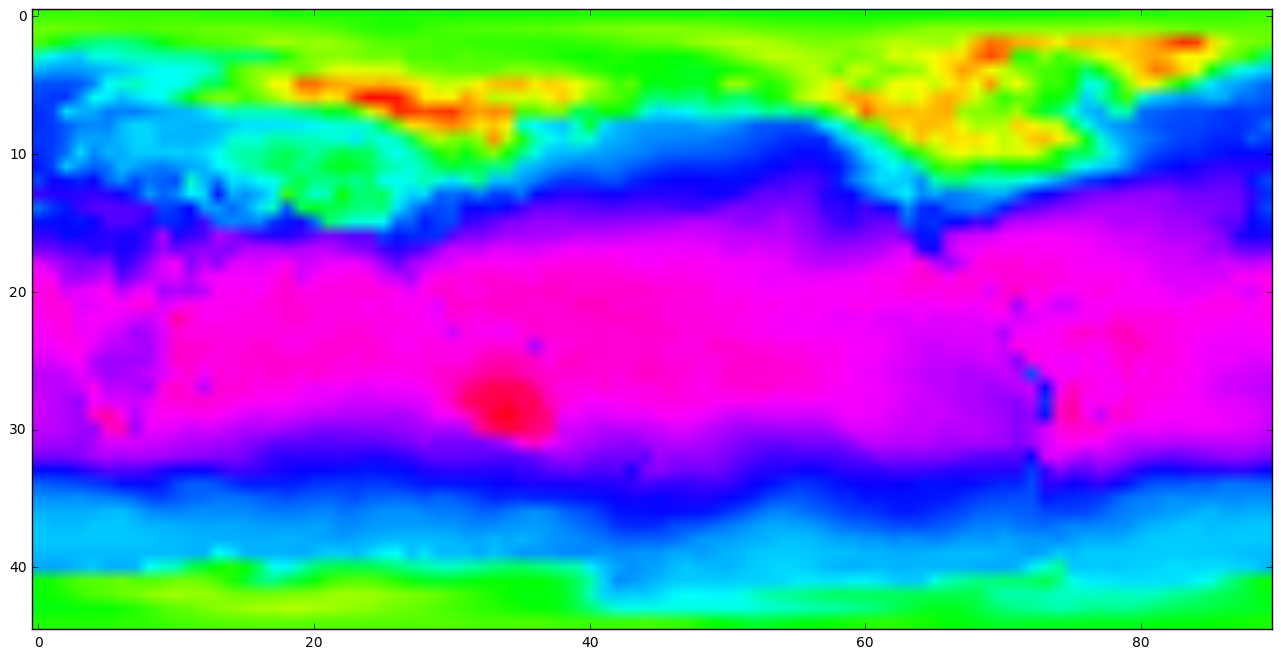

In [45]:
from matplotlib import pyplot as plt
%matplotlib inline

fig = plt.figure(figsize=(16, 8))
plt.imshow(dsets[0][::4, ::4], cmap='hsv')

## Integrate with `dask.array`

Make a list of `dask.array` objects out of your list of `h5py.Dataset` objects using the `da.from_array` function with a chunk size of `(500, 500)`.

In [46]:
import h5py
from glob import glob
import os

filenames = sorted(glob(os.path.join('data', 'weather-small', '*.hdf5')))

In [47]:
first_file = filenames[0]
print(first_file)

data\weather-small\2014-01-01.hdf5


In [48]:
hdf5_data = h5py.File(first_file)['/t2m']

In [ ]:
print(hdf5_data)

In [ ]:
import numpy as np
np_data = np.array(hdf5_data)
print(np_data)

In [ ]:
import dask.array as da
da_data = da.from_array(hdf5_data, chunks=(500, 500) )
print(da_data.mean().compute())

In [ ]:
list_of_dask_arrays = []
for file in filenames:
    dset = h5py.File(file)['/t2m']
    my_array   = da.from_array(dset, chunks=(500, 500) )
    list_of_dask_arrays.append(my_array)

In [ ]:
list_of_dask_arrays[0].mean().compute()

## Stack this list of `dask.array` objects into a single `dask.array` object with `da.stack`

Stack these along the first axis so that the shape of the resulting array is `(31, 5760, 11520)`.

In [ ]:
len(list_of_dask_arrays)

In [ ]:
stacked_da = da.stack(list_of_dask_arrays)
print(stacked_da)

## Plot the mean of this array along the time (`0th`) axis

In [ ]:
mean_da = stacked_da.mean(axis=0).compute()

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.imshow(mean_da, cmap='viridis')

## Plot the difference of the first day from the mean

In [ ]:
diff_da = (list_of_dask_arrays[0] - mean_da).compute()

In [ ]:
fig = plt.figure(figsize=(16, 8))
plt.imshow(diff_da, cmap='viridis')

## Solution

In [ ]:
%load solutions/Array-02.py


# Exercise 3:  Subsample and store

In the above exercise the result of our computation is small, so we can call `compute` safely.  Sometimes our result is still too large to fit into memory and we want to save it to disk.  In these cases you can use one of the following two functions

1.  `da.store`: Store dask.array into any object that supports numpy setitem syntax, e.g.

        f = h5py.File('myfile.hdf5')
        output = f.create_dataset(shape=..., dtype=...)
        
        da.store(my_dask_array, output)
        
2.  `da.to_hdf5`: A specialized function that creates and stores a `dask.array` object into an `HDF5` file.

        da.to_hdf5('data/myfile.hdf5', '/output', my_dask_array)
        
The task in this exercise is to use numpy step slicing to subsample the full dataset by a factor of two in both the latitude and longitude direction and then store this result to disk using one of the functions listed above.

As a reminder, Python slicing takes three elements

    start:stop:step

    >>> L = [1, 2, 3, 4, 5, 6, 7]
    >>> L[::3]
    [1, 4, 7]

## Solution

In [ ]:
%load solutions/Array-03.py

In [ ]:
!ls -ltrh tmp

# Limitations

Dask.array does not implement the entire numpy interface.  Users expecting this
will be disappointed.  Notably dask.array has the following failings:

1.  Dask does not implement all of ``np.linalg``.  This has been done by a
    number of excellent BLAS/LAPACK implementations and is the focus of
    numerous ongoing academic research projects.
2.  Dask.array does not support any operation where the resulting shape
    depends on the values of the array.  In order to form the dask graph we
    must be able to infer the shape of the array before actually executing the
    operation.  This precludes operations like indexing one dask array with
    another or operations like ``np.where``.
3.  Dask.array does not attempt operations like ``sort`` which are notoriously
    difficult to do in parallel and are of somewhat diminished value on very
    large data (you rarely actually need a full sort).
    Often we include parallel-friendly alternatives like ``topk``.
4.  Dask development is driven by immediate need, and so many lesser used
    functions, like ``np.full_like`` have not been implemented purely out of
    laziness.  These would make excellent community contributions.

<br>
*Copyright Continuum 2012-2016 All Rights Reserved.*